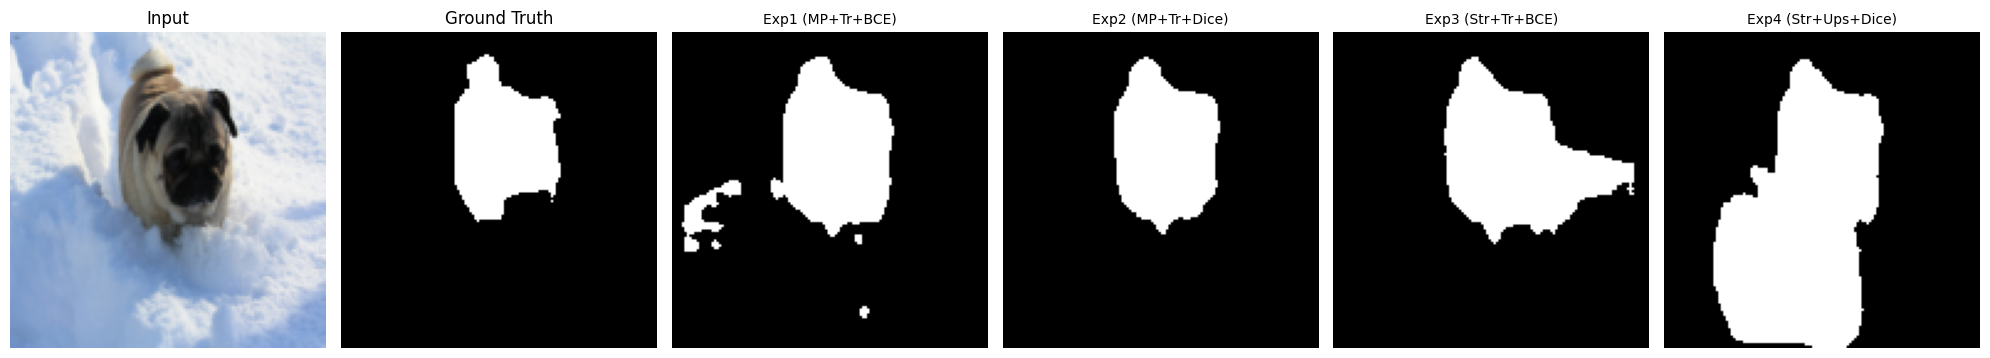

In [1]:
import torch
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('../src')
from dataset import PetDataset
from models import UNet

# Config
DATA_PATH = "../data/raw/Oxford-IIT-PetDataset/" 
device = "cpu"
ds = PetDataset(DATA_PATH, split='val')

# Pick a "hard" image (e.g., index 10, 25, or 50)
idx = 20 
img_tensor, mask_tensor = ds[idx]
input_batch = img_tensor.unsqueeze(0).to(device)

# Define configurations
configs = [
    ("Exp1 (MP+Tr+BCE)", 'mp', 'tr', "../results/Exp1_MP_Tr_BCE_best.pth"),
    ("Exp2 (MP+Tr+Dice)", 'mp', 'tr', "../results/Exp2_MP_Tr_Dice_best.pth"),
    ("Exp3 (Str+Tr+BCE)", 'str_conv', 'tr', "../results/Exp3_StrConv_Tr_BCE_best.pth"),
    ("Exp4 (Str+Ups+Dice)", 'str_conv', 'ups', "../results/Exp4_StrConv_Ups_Dice_best.pth")
]

# Plot
fig, axs = plt.subplots(1, 6, figsize=(20, 5))

# 1. Input
axs[0].imshow(img_tensor.permute(1, 2, 0))
axs[0].set_title("Input")
axs[0].axis('off')

# 2. Ground Truth
axs[1].imshow(mask_tensor[0], cmap='gray')
axs[1].set_title("Ground Truth")
axs[1].axis('off')

# 3. Predictions
for i, (name, down, up, path) in enumerate(configs):
    model = UNet(downsample_mode=down, upsample_mode=up).to(device)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location='cpu'))
        model.eval()
        with torch.no_grad():
            pred = model(input_batch)
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float().numpy()[0][0]
        
        axs[i+2].imshow(pred, cmap='gray')
        axs[i+2].set_title(name, fontsize=10)
    else:
        axs[i+2].text(0.5, 0.5, "Weights Missing", ha='center')
    
    axs[i+2].axis('off')

plt.tight_layout()
plt.savefig("../readme_comparison.png")
plt.show()